
# Generative Dog Images Competition

The dataset contains of 2 zip files:
*    20579 photos of dogs with lables
*     data about labels & file names


The goal of competition is to create a GAN which can generate a unique image of a dog.

A submission  would be the one best picture of dog. But this competition is closed and no longer accepting submissions :(


*So, I will just attach my generated photo in end of the notebook*

[Git repository with code and outputs](https://github.com/Julfyy/Julfyy-Coursera-DL-course)


# Import libraries

In [1]:
import pandas as pd 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Load dataset and pick random seed

In [3]:
import zipfile

with zipfile.ZipFile("../content/drive/MyDrive/generative-dog-images/all-dogs.zip","r") as zip_ref:
    zip_ref.extractall("/kaggle/generative-dog-images/all-dogs")

In [4]:
import zipfile

with zipfile.ZipFile("../content/drive/MyDrive/generative-dog-images/Annotation.zip","r") as zip_ref:
    zip_ref.extractall("/kaggle/generative-dog-images/Annotation")

In [37]:
SEED = 3
np.random.seed(SEED)
random_dim = 128
ROOT = '/kaggle/generative-dog-images/'

# Data Processing

**Read all images and put them into one keras dataset** 

Also converting rgb values to the range from 0 to 1 and redusing size to 64x64 px


Found 20579 files belonging to 1 classes.


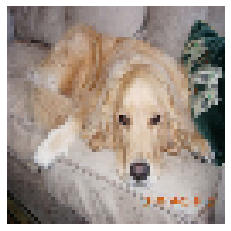

In [38]:
dataset = keras.preprocessing.image_dataset_from_directory(
    ROOT+"all-dogs/", label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

# GAN creation

GANs consist of a **discriminator**, a **generator** and an **optimizer**

**Discriminator** with input layer 64x64x3 px (because of rgb)

I'm using the leakyReLu and the Dropout layers for a better result and more controlled losses.

Activation function is sigmoid (we have only real and fake photos)

*Generator has the same parameters as Discriminator*


In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

In [ ]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

**Gan class** same as in lectures

In [39]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

To visualize our results let's create a monitor for our GAN. Just save some fake "photo" of dogs once in epoch (or in 10 epochs)

In [40]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("/kaggle/generative-dog-images/res/generated_img_%03d_%d.png" % (epoch, i))

# GAN Training - first attempt

I'll do only 5 epochs and small learning rate to see how this GAN will evolve. 
Loss function is binary crossentropy

In [ ]:
import time
epochs = 5  
os.mkdir("/kaggle/generative-dog-images/res")

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

start = time.time()

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)

print("--- %s seconds ---" % (time.time() - start))

# First result

The results are really far away from looking like a dog, so let's continue training 

In [ ]:
import cv2
    
fig = plt.figure(figsize=(9, 15))

for i in range(5):
    for j in range(3):
        img = cv2.imread(ROOT+"res/generated_img_%03d_%d.png" % (i, j))
        fig.add_subplot(5, 3, i*3+j+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title("Epoch %03d,photo #%d"%(i,j))

# GAN Training - second attempt

Photos are being saved every 10th epoch

In [41]:
class GANMonitor2(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        if (epoch % 10 == 0):
            for i in range(self.num_img):
                img = keras.preprocessing.image.array_to_img(generated_images[i])
                img.save("/kaggle/generative-dog-images/res/generated_img_%03d_%d.png" % (epoch, i))


In [ ]:
epochs2 = 50

start = time.time()
gan.fit(
    dataset, epochs=epochs2, callbacks=[GANMonitor2(num_img=3, latent_dim=latent_dim)]
)
print("--- %s seconds ---" % (time.time() - start))

# Results


The result is far from ideal, but I can recognize some features of dogs.
There should definitely be more epochs, but it takes too much time to train :(
  
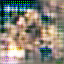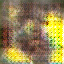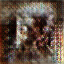
  

In [ ]:
fig = plt.figure(figsize=(9, 20))

for i in range(15):
    for j in range(3):
        img = cv2.imread(ROOT+"kaggle/generative-dog-images/res/generated_img_%03d_%d.png" % (i*10, j))
        fig.add_subplot(15, 3, i*3+j+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title("Epoch %03d,photo #%d"%(i*10+10,j))